In [1]:
import sys
import glob
import os
import ee
import math
import random
import pandas as pd
import numpy as np
import geopandas as gp
import seaborn as sns
import rsfuncs as rs

import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Numeric NLCD vals to class labels
nlcd= {0: "Open water",
1 : "Perennial ice/snow",
2 : "Developed",
3 : "Developed, low intensity",
4 : "Developed, medium intensity",
5 : "Developed high intensity",
6 : "Barren land (rock/sand/clay)",
7 : "Deciduous forest", 
8 : "Evergreen forest",
9 : "Mixed forest",
10 : "Dwarf scrub",
11 : "Shrub/scrub",
12 : "Grassland/herbaceous",
13 : "Sedge/herbaceous",
14 : "Lichens",
15 : "Moss",
16 : "Pasture/hay",
17 : "Cultivated crops",
18 : "Woody wetlands",
19 : "Emergent herbaceous wetlands"}


In [3]:
# Read data

In [4]:
data_dir = "../data"

states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]


In [5]:
# Read and format the RS data 

df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)

# Remove outliers
# df = df[~(np.abs(df.psi_rz-df.psi_rz.mean()) > (df.psi_rz.std()))]

In [6]:
# Filter the data

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]
df = df[df.lc_type != 4]
df = df[df.lc_type != 5]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

# Calculate spectral indices
# df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
# df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
# df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)

df['ndvi'] = (df.B5_filt - df.B4_filt) / (df.B5_filt + df.B4_filt)
df["ndmi"] = (df.B5_filt - df.B6_filt) / (df.B5_filt + df.B6_filt)
df["evi"] = 2.5*(df.B5_filt - df.B4_filt) / (df.B5_filt + 6*df.B4_filt - 7.5*df.B2_filt + 1)

# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean of the 3 pixels
vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))


df['vv'] = vv_eff
df['hv'] = hv_eff

In [7]:
# Select the filtered sites from the shapefile

In [8]:
validsites = [x for x in sites.id if int(x) in df.site.unique()]
sites = sites[sites.id.isin(validsites)]

In [9]:
# Join the scan data and rs data

# Scan join cols
join_cols = ["id","elev", "clay_fract", "silt_fract", "sand_fract", "a", "b"]
jdf = sites[join_cols]

In [10]:
df = pd.merge(df, jdf.astype(float), right_on= "id", left_on= "site", how = "inner")

### Compute the depth weighted root zone soil moisture for each site

Based on Jackson et al., 1996:

https://www.agro.uba.ar/users/sala/pdfs/063-oecol96c.pdf

Jackson, R. B., Canadell, J., Ehleringer, J. R., Mooney, H. A., Sala, O. E., & Schulze, E. D. (1996). A global analysis of root distributions for terrestrial biomes. Oecologia, 108(3), 389-411.

#### Equation 1:  $ Y =  1- \beta ^d $

Y is root density, d is depth, $\beta$ is empirical parameter

#### From table 1
grasses: $\beta$ = 0.952
trees: $\beta$ = 0.970
shrubs: $\beta$ = 0.978
...

In [11]:
def calc_y(depth,beta):
    y = 1-beta**depth
    return y

def calc_weighted_avg(ys):
    return [x/sum(ys) for x in ys]

In [12]:
# These beta values correspond to landcover types in NLCD 
beta_dict = { 
        12: 0.952,
        11: 0.978,
        17: 0.961,
        7: 0.970,
        16: 0.952,
        8: 0.970,
        6: 0.914, 
        }

In [13]:
# Now loop through each site id, read the SCAN soil moisture from data dir, compute the depth averaged SM

In [14]:
# Helper to read a SCAN site text file and return the data as a dataframe 

def read_sm_file(filename):
    with open(filename) as f:
        contents = f.readlines()

    data = []
    for line in contents:
        if line[0:1] == "#":
            continue
        else:
            data.append(line)

    headers = [x.replace("Soil Moisture Percent","smp").replace(" ","_") for x in data[0].split(",")]
    cols = [x.strip("\n").split(",") for x in data[1:]]

    df = pd.DataFrame(cols, columns = headers)
    
    return df


In [15]:
# Heres the big loop

In [16]:
# Setup the results datastructures 
spatial_stats = {}
temporal_stats = {}

lcstats = { 
        12: [],
        11: [],
        17: [],
        7: [],
        16: [],
        8: [],
        6: [], 
        }

lcstats_daily = { 
        12: [],
        11: [],
        17: [],
        7: [],
        16: [],
        8: [],
        6: [], 
        }

out_dfs = []

for idx, row in sites.iterrows():
        
    print("Processings site no {}".format(row.id))
    
    # Get the corresponding SCAN data file from data folder
    site_id = row.id
    sm_file = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if site_id in x][0]
    sm_dat = read_sm_file(sm_file)
    sm_dat['Date'] =  pd.to_datetime(sm_dat['Date'], format='%Y%m%d %H:%M')
    sm_dat.set_index('Date', inplace=True)
    
    if sm_dat.empty:
        print("no valid data")
        continue 
    
    # Rename the columns to the depths in cm (approx)
    sm_dat.rename(columns= { 
                        sm_dat.columns[0]: "5",
                        sm_dat.columns[1]: "10",
                        sm_dat.columns[2]: "20",
                        sm_dat.columns[3]: "50",
                        sm_dat.columns[4]: "100"
                        }, inplace = True)
    
    # Eliminate whitespace and drop rows with nans 
    sm_dat = sm_dat.replace(r'^\s*$', np.nan, regex=True)
    sm_dat = sm_dat.dropna()
    
    if sm_dat.empty:
        print("no valid data")
        continue 
        
    # Get the RS data for that site 
    rsdf = df[df.id == int(row.id)]
    lct = rsdf.lc_type.unique()[0]
    beta = beta_dict[lct]
    
    # Calculate the weighted sum for each row 
    was = []
    wsvar = []
    for idx, x in sm_dat.iterrows():
        depths = x.index.values
        depths = [float(x) for x in depths]
        ys = [calc_y(x,beta) for x in depths]
        wa = np.array(calc_weighted_avg(ys))
        smvals = [float(j) for j in x.values]
        weighted_sum = np.array(smvals*wa).sum()
        wsvar.append(np.var(np.array(smvals)))
        was.append(weighted_sum)
    
    # append the weighted sums to the dataframe 
    sm_dat['wa'] = was
    
    # Compute the sm anomaly across all times 
    sm_dat['wa_anom'] = sm_dat['wa'] - np.mean(sm_dat['wa'])
    
    # Rename numeric cols 
    sm_dat = sm_dat.rename(columns={"5": "d5", "10": "d10", "20":"d20", "50": "d50", "100":"d100"})
    
    # For each landcover type, append all soil moisture data 
    lcstats[lct].append([sm_dat])
    
    # Get the site specific mean and var for all times 
    spatial_stats[row.id] = [np.mean(sm_dat.wa),np.std(sm_dat.wa)**2]
    
    # For every landcover type, get data between 3 am - 7 am and append
    sm_dat_daily = sm_dat.between_time('4:00', '7:00')
    lcstats_daily[lct].append([sm_dat_daily])
    
    # Get the depth weighted mean from 4-7 am each day 
    temporal_stats[row.id] = [np.mean(sm_dat_daily.wa), np.std(sm_dat_daily.wa)**2]

    # For all the dates with RS data, extract the depth averaged sm and join it to the master df
    sdf = df[df.site == int(row.id)]
    sdf.set_index(pd.to_datetime(sdf.date), inplace = True)
    dates = sdf.index
    
    rzsm = []
    
    # for each date with RS data, select matching 3-7 am from the SCAN data 
    for i in dates:
        starttime = i.replace(second=0, microsecond=0, minute=0, hour=3)
        endtime = starttime+timedelta(hours= 4)
        ddf = pd.DataFrame(sm_dat[starttime:endtime])
        rzsm.append(ddf)
    
    # daily (i.e. 3am - 7 am) means
    resampled = pd.concat(rzsm).resample("D").mean()
    sdf = sdf.resample("D").mean()
        
    # merge the resampled df to the site df
    final = pd.merge(sdf, resampled, left_index = True, right_index = True, how = "inner").dropna()
        
    out_dfs.append(final)
    print("====" * 10 )

Processings site no 2214
no valid data
Processings site no 2215
Processings site no 2189
Processings site no 2190
Processings site no 2187
Processings site no 2183
Processings site no 2191
Processings site no 2192
Processings site no 2185
Processings site no 2184
Processings site no 2218
Processings site no 2149
Processings site no 2217
Processings site no 2186
Processings site no 2219
Processings site no 2197
Processings site no 2148
no valid data
Processings site no 674
no valid data
Processings site no 2117
Processings site no 2019
Processings site no 2121
Processings site no 581
Processings site no 2119
Processings site no 808
Processings site no 2118
Processings site no 2111
Processings site no 2069
Processings site no 2015
Processings site no 2172
Processings site no 2107
Processings site no 2168
Processings site no 2169
Processings site no 2171
Processings site no 2108
Processings site no 2216
no valid data
Processings site no 2145
Processings site no 2141
Processings site no 21

In [17]:
for k,v in lcstats.items():
    vdfs = []
    for i in v:
        vdfs.append(i[0])
    print("{} n sites = {} n measurements = {} ".format(nlcd[k], len(v), len(pd.concat(vdfs))))
    mean_sm = np.mean(pd.concat(vdfs).wa)
    var_sm = np.var(pd.concat(vdfs).wa)
    
    print(mean_sm, var_sm)

Grassland/herbaceous n sites = 9 n measurements = 229216 
15.965544041815443 58.981661796513045
Shrub/scrub n sites = 32 n measurements = 962495 
12.050705236815649 69.77404196732542
Cultivated crops n sites = 20 n measurements = 633070 
19.772173780026108 85.7407729457405
Deciduous forest n sites = 1 n measurements = 20154 
28.929844370655164 9.341728974769548
Pasture/hay n sites = 3 n measurements = 102442 
22.532646717882013 9.629696391640897
Evergreen forest n sites = 4 n measurements = 130735 
14.844466756091556 61.75458686201086
Barren land (rock/sand/clay) n sites = 2 n measurements = 46831 
9.860457045480812 8.453275141511414


In [18]:
for k,v in lcstats_daily.items():
    vdfs = []
    for i in v:
        vdfs.append(i[0])
    print("{} n sites = {} n measurements = {} ".format(nlcd[k], len(v), len(pd.concat(vdfs))))
    mean_sm = np.mean(pd.concat(vdfs).wa)
    var_sm = np.var(pd.concat(vdfs).wa)
    
    print(mean_sm, var_sm)

Grassland/herbaceous n sites = 9 n measurements = 37924 
15.928919123010031 58.40837724440013
Shrub/scrub n sites = 32 n measurements = 160489 
12.000489193205876 69.3693613315109
Cultivated crops n sites = 20 n measurements = 105196 
19.767833188090613 85.86029609824348
Deciduous forest n sites = 1 n measurements = 3358 
28.93235423420433 9.306503820676486
Pasture/hay n sites = 3 n measurements = 17079 
22.490105880577243 9.617366736600195
Evergreen forest n sites = 4 n measurements = 21778 
14.815599323104061 61.9593665230664
Barren land (rock/sand/clay) n sites = 2 n measurements = 7804 
9.70860679792858 8.297908745329377


# For overpasses times: 

make violin plots to inspect the mean and variance of raw data weighted averages and weighted average anomaly 

In [ ]:
analysis_df = pd.concat(out_dfs)
# analysis_df.columns = lclabels

<a list of 7 Text xticklabel objects>


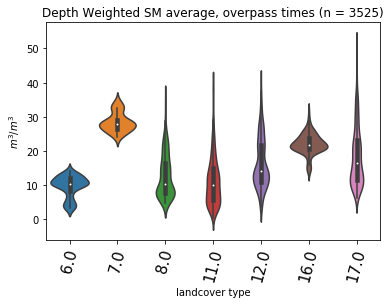

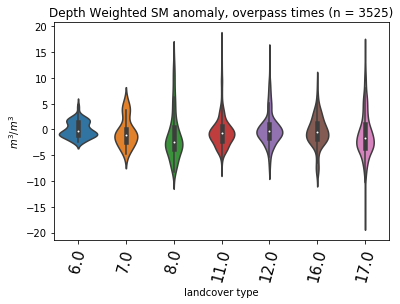

In [ ]:
# Plot depth weighted sum of SM violin plot for each lc type only during overpass dates 
p=sns.violinplot(x="lc_type", y="wa", data=analysis_df)
plt.title("Depth Weighted SM average, overpass times (n = {})".format(str(len(analysis_df))))
plt.xlabel("landcover type")
print(plt.gca().get_xticklabels())
# p.set_xticklabels([nlcd[k] for k in plt.gca().get_xticklabels()])
plt.xticks(rotation=75, size = 15)
plt.ylabel("$m^3/ m^3$")
plt.show()

# Plot anomalies of SM violin plot for each lc type only during overpass dates 
p2 = sns.violinplot(x="lc_type", y="wa_anom", data=analysis_df)
# plt.title("Depth Weighted SM anomaly ($X_i' = X_i - \bar{x} $)" + ", overpass times (n = {})".format(str(len(analysis_df))))
plt.title("Depth Weighted SM anomaly, overpass times (n = {})".format(str(len(analysis_df))))

plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
# p2.set_xticklabels(lclabels)

plt.show()

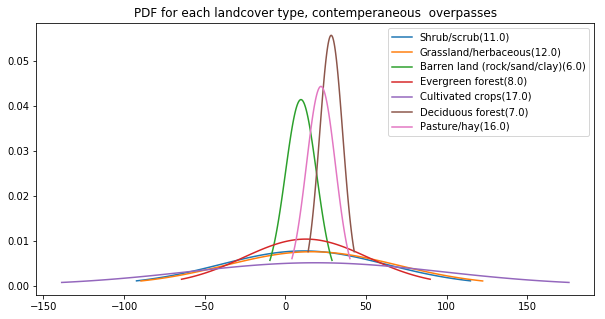

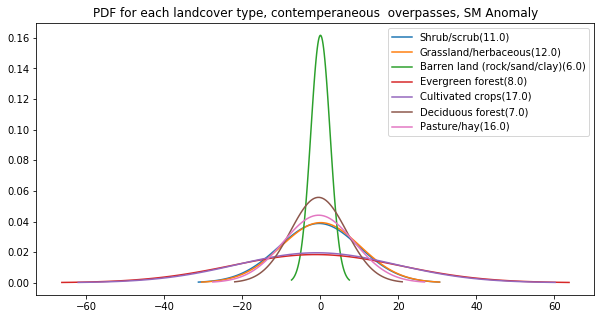

In [ ]:
plt.figure(figsize =(10,5))

for i in analysis_df.lc_type.unique():
    lcdf = analysis_df[analysis_df.lc_type==i]
    lctype = lcdf.lc_type.unique()[0]
    mu = np.mean(lcdf.wa.values)
    sigma = np.var(lcdf.wa.values)
    x = np.linspace(mu - 2*sigma, mu + 2*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label = nlcd[lctype]+ "({})".format(lctype) )

plt.title("PDF for each landcover type, contemperaneous  overpasses")
plt.legend()
plt.show()

plt.figure(figsize =(10,5))

for i in analysis_df.lc_type.unique():
    lcdf = analysis_df[analysis_df.lc_type==i]
    lctype = lcdf.lc_type.unique()[0]
    mu = np.mean(lcdf.wa_anom.values)
    sigma = np.var(lcdf.wa_anom.values)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label = nlcd[lctype]+ "({})".format(lctype) )

plt.title("PDF for each landcover type, contemperaneous  overpasses, SM Anomaly")
plt.legend()
plt.show()

In [ ]:
# Print the variances per lc type for weighted avg
print("Weighted Average variance: \n")

for i in analysis_df.lc_type.unique():
    lcdf = analysis_df[analysis_df.lc_type==i]
    lctype = lcdf.lc_type.unique()[0]
    sigma = np.var(lcdf.wa.values)
    mu = np.mean(lcdf.wa.values)
    print(lctype, nlcd[lctype], "variance = ", round(sigma,2), "mean = ", round(mu,2))

Weighted Average variance: 

11.0 Shrub/scrub variance =  51.78 mean =  11.26
12.0 Grassland/herbaceous variance =  52.97 mean =  16.45
6.0 Barren land (rock/sand/clay) variance =  9.63 mean =  9.71
8.0 Evergreen forest variance =  38.56 mean =  12.74
17.0 Cultivated crops variance =  78.66 mean =  18.61
7.0 Deciduous forest variance =  7.15 mean =  28.45
16.0 Pasture/hay variance =  8.99 mean =  22.09


In [ ]:

# Print the variances per lc type for weighted avg anomaly
print("Weighted Average Anomaly variance: \n")

for i in analysis_df.lc_type.unique():
    lcdf = analysis_df[analysis_df.lc_type==i]
    lctype = lcdf.lc_type.unique()[0]
    sigma = np.var(lcdf.wa_anom.values)
    mu = np.mean(lcdf.wa_anom.values)
    print(lctype, nlcd[lctype], "variance = ", round(sigma,2), "mean = ", round(mu,2))

Weighted Average Anomaly variance: 

11.0 Shrub/scrub variance =  10.3 mean =  -0.35
12.0 Grassland/herbaceous variance =  10.16 mean =  0.09
6.0 Barren land (rock/sand/clay) variance =  2.47 mean =  0.03
8.0 Evergreen forest variance =  21.67 mean =  -1.25
17.0 Cultivated crops variance =  20.37 mean =  -0.95
7.0 Deciduous forest variance =  7.15 mean =  -0.48
16.0 Pasture/hay variance =  9.04 mean =  -0.43


In [ ]:
# N samples per landcover type 
analysis_df.lc_type.value_counts()

11.0    1403
17.0    1123
12.0     464
8.0      217
6.0      147
16.0     144
7.0       27
Name: lc_type, dtype: int64

# All times 

In [ ]:
lcs={}
lcs_anom = {}
for k,v in lcstats.items():
    vdfs = []
    for i in v:
        vdfs.append(i[0])
    print("{} {} n sites = {} n measurements = {} ".format(k, nlcd[k], len(v), len(pd.concat(vdfs))))
    mean_sm = np.mean(pd.concat(vdfs).wa)
    var_sm = np.var(pd.concat(vdfs).wa)
    lcs[k] = [pd.concat(vdfs).wa.values]
    lcs_anom[k] = [pd.concat(vdfs).wa_anom.values]
    
    print("mean = {} variance = {}".format(round(mean_sm,2), round(var_sm,2)))

12 Grassland/herbaceous n sites = 9 n measurements = 229216 
mean = 15.97 variance = 58.98
11 Shrub/scrub n sites = 32 n measurements = 962495 
mean = 12.05 variance = 69.77
17 Cultivated crops n sites = 20 n measurements = 633070 
mean = 19.77 variance = 85.74
7 Deciduous forest n sites = 1 n measurements = 20154 
mean = 28.93 variance = 9.34
16 Pasture/hay n sites = 3 n measurements = 102442 
mean = 22.53 variance = 9.63
8 Evergreen forest n sites = 4 n measurements = 130735 
mean = 14.84 variance = 61.75
6 Barren land (rock/sand/clay) n sites = 2 n measurements = 46831 
mean = 9.86 variance = 8.45


In [ ]:
# Plot the means / variances for all data at all times

In [ ]:
lckeys = [k for k,v in lcstats.items()]
lclabels = [nlcd[k] for k,v in lcstats.items()]

In [ ]:
dwa = dict(zip(lckeys, [v[0] for k,v in lcs.items()]))
wadf = pd.DataFrame(dict([(nlcd[k],pd.Series(v)) for k,v in dwa.items()]))

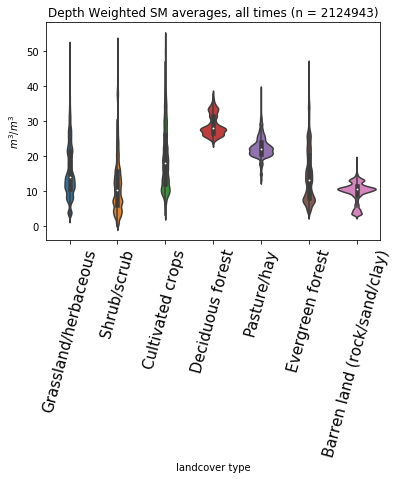

In [ ]:
sns.violinplot(data=wadf)
plt.title("Depth Weighted SM averages, all times (n = {})".format(str(wadf.count().sum())))
plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
plt.show()

In [ ]:
dwa_anom = dict(zip(lckeys, [v[0] for k,v in lcs_anom.items()]))
wadf_anom = pd.DataFrame(dict([(nlcd[k],pd.Series(v)) for k,v in dwa_anom.items()]))

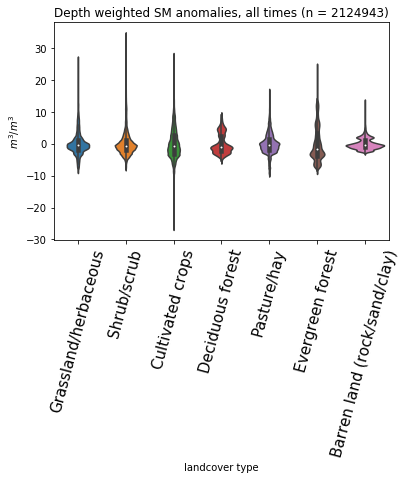

In [ ]:
sns.violinplot(data=wadf_anom)
plt.title("Depth weighted SM anomalies, all times (n = {})".format(str(wadf_anom.count().sum())))
plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
plt.show()

# 3 am - 7 am on all days

In [ ]:

lcs_daily={}
lcs_anom_daily = {}

for k,v in lcstats_daily.items():
    vdfs = []
    for i in v:
        vdfs.append(i[0])
    print("{} {} n sites = {} n measurements = {} ".format(k, nlcd[k], len(v), len(pd.concat(vdfs))))
    mean_sm = np.mean(pd.concat(vdfs).wa)
    var_sm = np.var(pd.concat(vdfs).wa)
    lcs_daily[k] = [pd.concat(vdfs).wa.values]
    lcs_anom_daily[k] = [pd.concat(vdfs).wa_anom.values]
    
    print("mean = {} variance = {}".format(round(mean_sm,2), round(var_sm,2)))

12 Grassland/herbaceous n sites = 9 n measurements = 37924 
mean = 15.93 variance = 58.41
11 Shrub/scrub n sites = 32 n measurements = 160489 
mean = 12.0 variance = 69.37
17 Cultivated crops n sites = 20 n measurements = 105196 
mean = 19.77 variance = 85.86
7 Deciduous forest n sites = 1 n measurements = 3358 
mean = 28.93 variance = 9.31
16 Pasture/hay n sites = 3 n measurements = 17079 
mean = 22.49 variance = 9.62
8 Evergreen forest n sites = 4 n measurements = 21778 
mean = 14.82 variance = 61.96
6 Barren land (rock/sand/clay) n sites = 2 n measurements = 7804 
mean = 9.71 variance = 8.3


In [ ]:
dwa_3_7 = dict(zip(lckeys, [v[0] for k,v in lcs_daily.items()]))
wadf_3_7 = pd.DataFrame(dict([(nlcd[k],pd.Series(v)) for k,v in dwa_3_7.items()]))

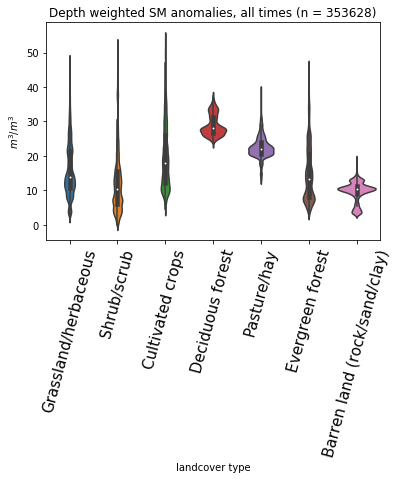

In [ ]:
sns.violinplot(data=wadf_3_7)
plt.title("Depth weighted SM anomalies, all times (n = {})".format(str(wadf_3_7.count().sum())))
plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
plt.show()

In [ ]:
dwa_3_7_anom = dict(zip(lckeys, [v[0] for k,v in lcs_anom_daily.items()]))
wadf_3_7_anom = pd.DataFrame(dict([(nlcd[k],pd.Series(v)) for k,v in dwa_3_7_anom.items()]))

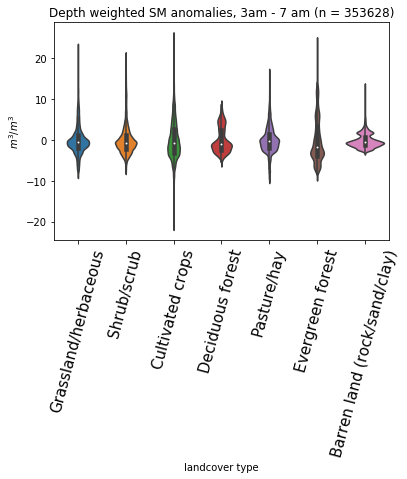

In [ ]:
sns.violinplot(data=wadf_3_7_anom)
plt.title("Depth weighted SM anomalies, 3am - 7 am (n = {})".format(str(wadf_3_7_anom.count().sum())))
plt.xlabel("landcover type")
plt.ylabel("$m^3/ m^3$")
plt.xticks(rotation=75, size = 15)
plt.show()

In [ ]:
# For each landcover type, look at the mean / variance for each depth (5, 10, 20, 50, 100) and the weighted average

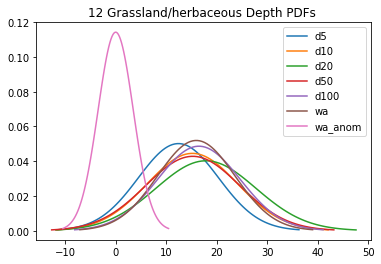

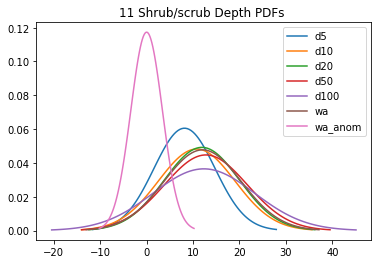

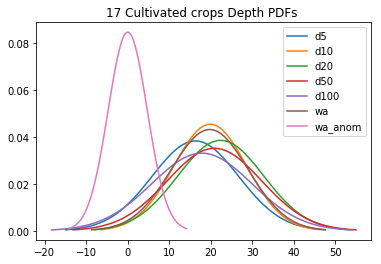

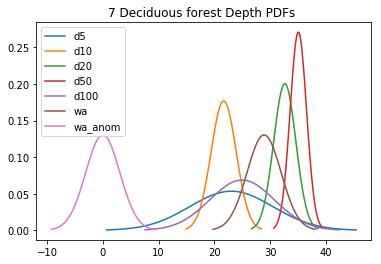

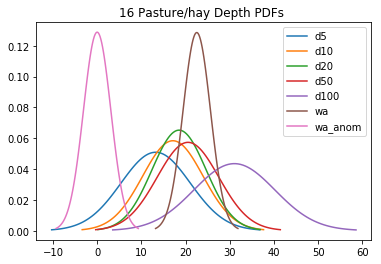

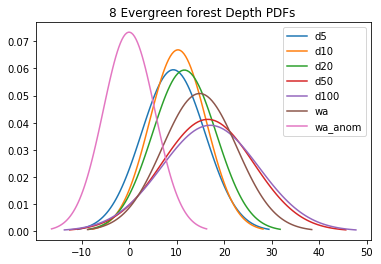

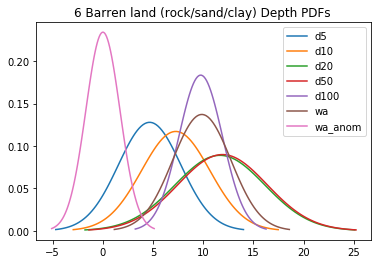

In [ ]:
for k,v in lcstats.items():
    vdfs = []
    for i in v:
        vdfs.append(i[0])

    alldat = pd.concat(vdfs)
    alldat = alldat.apply(pd.to_numeric)

    depthstats = {}
    for i in alldat.columns:
        depthstats[i] = [np.mean(alldat[i]),np.var(alldat[i])]

    for key,val in depthstats.items():
        mu,sigma = val[0], val[1]
        sigma = math.sqrt(sigma)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        plt.plot(x, stats.norm.pdf(x, mu, sigma), label = key)

        plt.title("{} {} Depth PDFs ".format(k,nlcd[k]))
        plt.legend()

    plt.show()
    

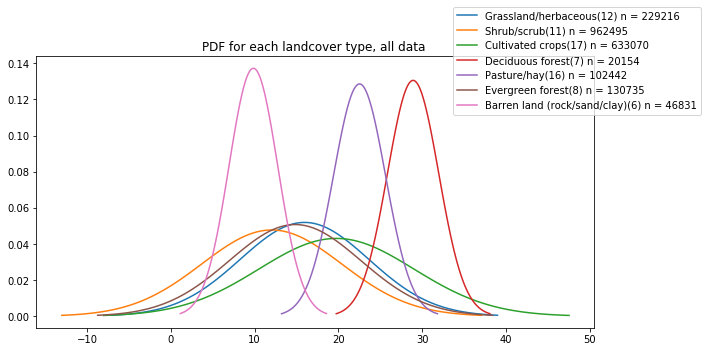

In [ ]:
# Plot the PDF for each landcover type (all times)

plt.figure(figsize = (10,5))

for k,v in lcstats.items():
    
    vdfs = []
    for i in v:
        vdfs.append(i[0])

    alldat = pd.concat(vdfs)
    alldat = alldat.apply(pd.to_numeric)
    mu = np.mean(alldat.wa)
    var = np.var(alldat.wa)
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label = nlcd[k]+ "({}) n = {}".format(k, len(alldat)) )

plt.title("PDF for each landcover type, all data ")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
plt.show()

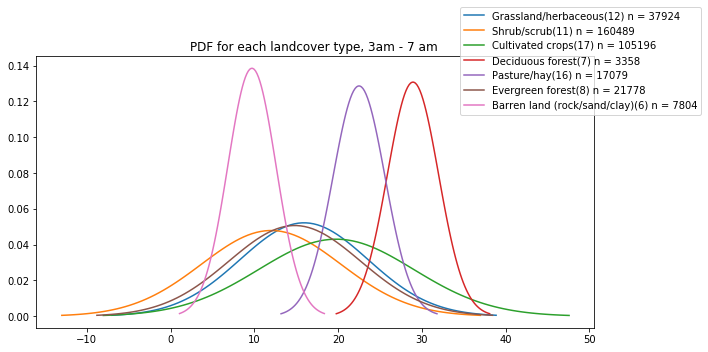

In [ ]:
# Plot the PDF for each landcover type (all times)

plt.figure(figsize = (10,5))

for k,v in lcstats_daily.items():
    
    vdfs = []
    for i in v:
        vdfs.append(i[0])

    alldat = pd.concat(vdfs)
    alldat = alldat.apply(pd.to_numeric)
    mu = np.mean(alldat.wa)
    var = np.var(alldat.wa)
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label = nlcd[k]+ "({}) n = {}".format(k, len(alldat)) )

plt.title("PDF for each landcover type, 3am - 7 am ")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
plt.show()

# Look at site specific means / vars

In [ ]:
# Compile the spatial and temporal stats 

tempdf = []

for k,v in temporal_stats.items():
    sdf = sites[sites.id == k]
    sdf['sm_mean_t'] = v[0]
    sdf['sm_var_t'] = v[1]
    tempdf.append(sdf)

spatialdf = []

for k,v in spatial_stats.items():
    sdf = sites[sites.id == k]
    sdf['sm_mean_s'] = v[0]
    sdf['sm_var_s'] = v[1]
    spatialdf.append(sdf)

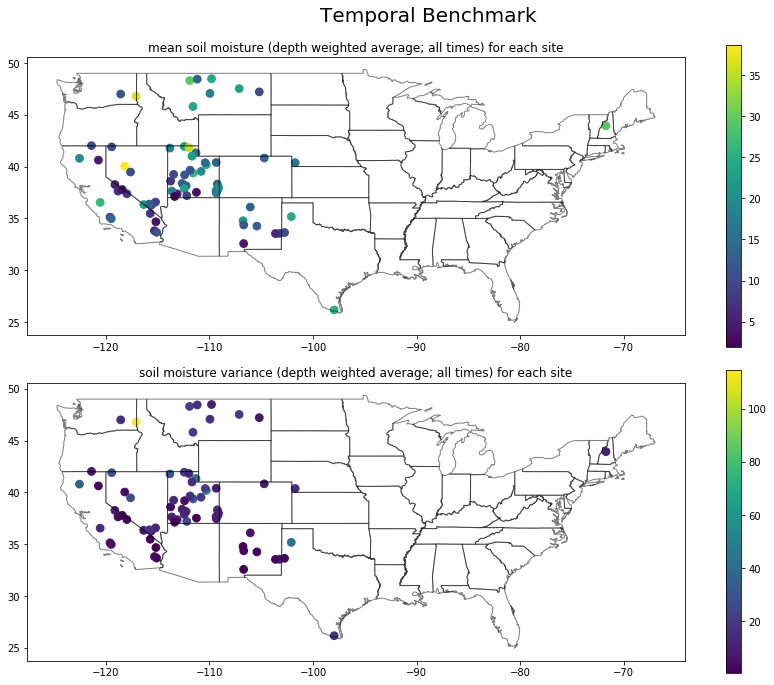

In [ ]:
fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Temporal Benchmark", size = 20)

ax[0].set_title("mean soil moisture (depth weighted average; all times) for each site")
pd.concat(tempdf).plot(ax = ax[0], column = "sm_mean_t",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("soil moisture variance (depth weighted average; all times) for each site")
pd.concat(tempdf).plot(ax = ax[1], column = "sm_var_t",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

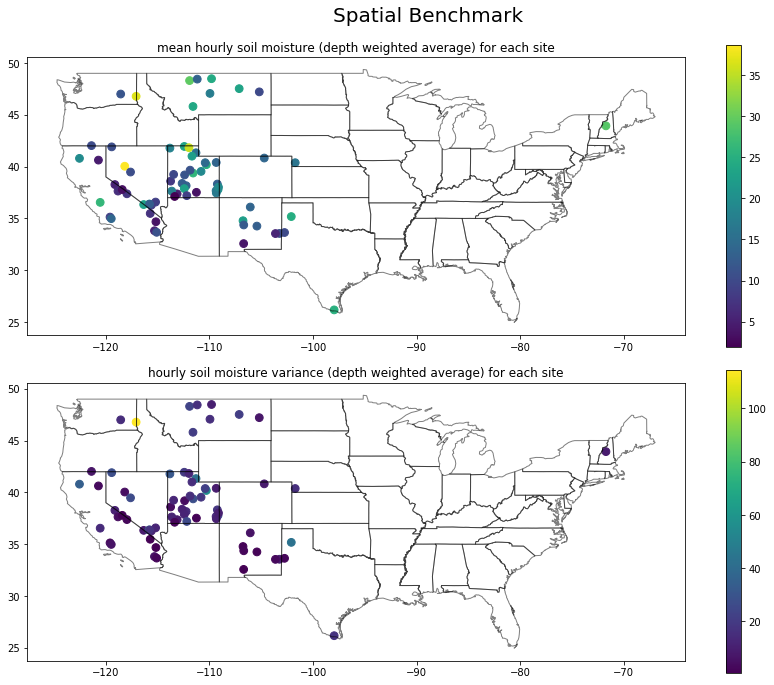

In [ ]:
fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Spatial Benchmark", size = 20)

ax[0].set_title("mean hourly soil moisture (depth weighted average) for each site")
pd.concat(spatialdf).plot(ax = ax[0], column = "sm_mean_s",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("hourly soil moisture variance (depth weighted average) for each site")
pd.concat(spatialdf).plot(ax = ax[1], column = "sm_var_s",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

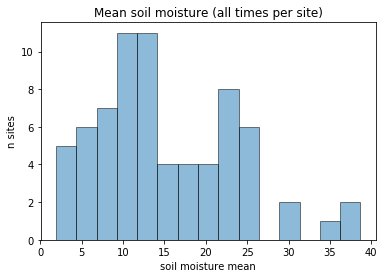

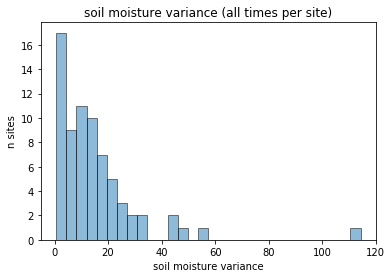

In [ ]:
plt.hist(pd.concat(tempdf).sm_mean_t.values, bins = 15, alpha = 0.5, edgecolor='black',)
plt.title("Mean soil moisture (all times per site)")
plt.xlabel("soil moisture mean")
plt.ylabel("n sites")
plt.show()
plt.hist(pd.concat(tempdf).sm_var_t.values, bins = 30, alpha = 0.5, edgecolor='black',)
plt.title("soil moisture variance (all times per site)")
plt.xlabel("soil moisture variance")
plt.ylabel("n sites")
plt.show()

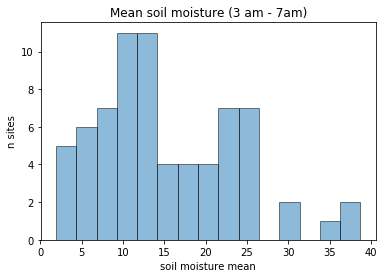

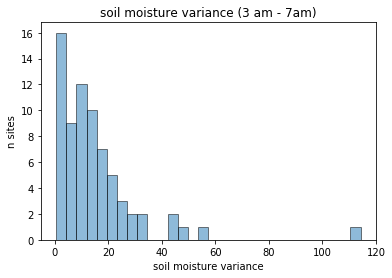

In [ ]:
plt.hist(pd.concat(spatialdf).sm_mean_s.values, bins = 15, alpha = 0.5, edgecolor='black',)
plt.title("Mean soil moisture (3 am - 7am)")
plt.xlabel("soil moisture mean")
plt.ylabel("n sites")
plt.show()
plt.hist(pd.concat(spatialdf).sm_var_s.values, bins = 30, alpha = 0.5, edgecolor='black',)
plt.title("soil moisture variance (3 am - 7am)")
plt.xlabel("soil moisture variance")
plt.ylabel("n sites")
plt.show()

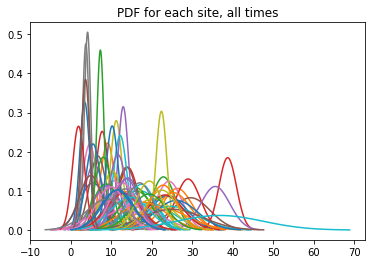

Text(0.5, 1.0, 'PDF for each site, 3am - 7am')

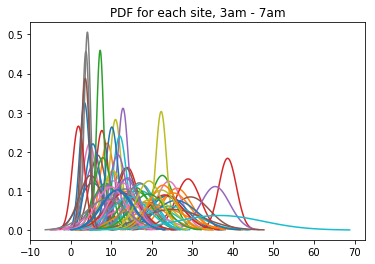

In [ ]:
for k,v in spatial_stats.items():
    mu = v[0]
    var = v[1]
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.title("PDF for each site, all times")
plt.show()

for k,v in temporal_stats.items():
    mu = v[0]
    var = v[1]
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.title("PDF for each site, 3am - 7am")

# Make baseline predictions: 

Use the spatial and temporal mean at each site to calculate a baseline RMSE, bias, R^2:

$$R^2 =  1 - \frac {\sum_{i=1}^{n} (x_i - \hat{x})^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2 }$$

$$RMSE =  \sqrt{{ \frac{{\sum_{i=1}^{n} (x_i - \bar{x})^2}} {n} }}$$

$$bias =  \frac {1}{n} {\sum_{i=1}^{n} (x_i - \bar{x})^2 }$$


# Baseline 1: Site means at overpass times

In [ ]:
# Take the site specific average and calc R^2 and RMSE 

In [ ]:
site_means = pd.concat(spatialdf)
site_means.id = site_means.id.astype(np.float64)

keepcols = [x for x in  site_means.columns if x not in analysis_df.columns]

In [ ]:
site_means.id.astype(int)
analysis_df.id.astype(int)
adf = analysis_df.merge(site_means, on='id')

In [ ]:
# Calc R^2
A = np.vstack([adf.sm_mean_s, np.ones(len(adf.sm_mean_s))]).T
solution = np.linalg.lstsq(A, adf.wa)
m, c = solution[0]
residuals = solution[1]
r2 = 1 - residuals / sum((adf.wa - adf.wa.mean())**2) 

In [ ]:
#  RMSE, bias
naive_rmse = ((adf.wa - adf.sm_mean_s) ** 2).mean() ** .5
naive_bias = ((adf.wa - adf.sm_mean_s)).mean()

print(naive_rmse)
print(naive_bias)

3.7724759776605614
-0.5271472685586385


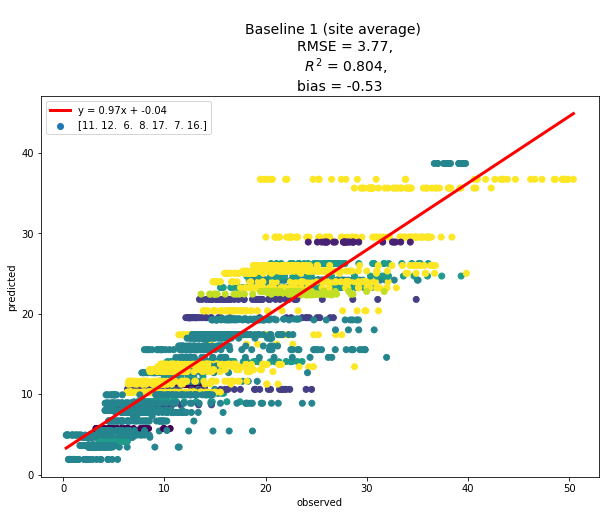

In [ ]:
plt.figure(figsize = (10,7))
plt.scatter(adf.wa,adf.sm_mean_s, c = adf.lc_type, label = adf.lc_type.unique())
plt.plot(np.unique(adf.wa.values), np.poly1d(np.polyfit(adf.wa.values, adf.sm_mean_s.values, 1))(np.unique(adf.wa.values)), 
         c = "red", linewidth = 3,
         label='y = {}x + {}'.format(round(m,2),round(c,2)))
plt.legend()
plt.ylabel("predicted")
plt.xlabel("observed")
plt.title('''
      Baseline 1 (site average)
            RMSE = {}, 
            $R^2$ = {}, 
          bias = {} '''.format(round(naive_rmse,2), round(r2[0],3), round(naive_bias,2)), size = 14 )
plt.show()

In [ ]:
# Distribution of Site specific RMSEs, bias, variances
rmses = []
biases = []
variances = []
for i in adf.site.unique():
    sdf = adf[adf.site == i]
    site_rmse = ((sdf.wa - sdf.sm_mean_s) ** 2).mean() ** .5
    site_var = np.var(sdf.wa)
    site_bias = ((sdf.wa - sdf.sm_mean_s)).mean()
    variances.append(site_var)
    rmses.append(site_rmse)
    biases.append(site_bias)

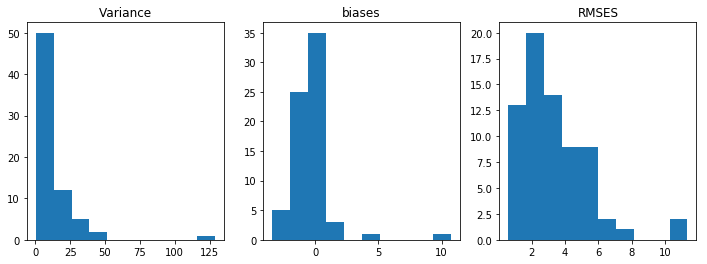

In [ ]:
plt.figure(figsize = (12,4))
plt.title("Site specific statistics")

plt.subplot(1,3,1)
plt.hist(np.array(variances))
plt.title("Variance")

plt.subplot(1,3,2)
plt.hist(np.array(biases))
plt.title("biases")

plt.subplot(1,3,3)
plt.hist(np.array(rmses))
plt.title("RMSES")

plt.show()

# Baseline 2: Landcover type means - all times, 3am - 7 am

In [ ]:
for k,v in lcstats.items():
    
    vdfs = []
    for i in v:
        vdfs.append(i[0])

    alldat = pd.concat(vdfs)
    alldat = alldat.apply(pd.to_numeric)

In [ ]:
lct_mean_all = []
lct_mean_3_7 = []

for i in analysis_df.iterrows():
    lct = i[1]['lc_type']
    
#     print(len(lcstats[lct]))
    
    lctm = np.mean(pd.concat([x[0] for x in lcstats[lct]]).wa)
    lct_mean_all.append(lctm)
    
    lctm_3_7 = np.mean(pd.concat([x[0] for x in lcstats_daily[lct]]).wa)

#     print(len(pd.concat([x[0] for x in lcstats[lct]]).wa))
    
#     print(lctm, lctm_3_7)
    lct_mean_3_7.append(lctm_3_7)


In [ ]:
analysis_df['lct_mean_all'] = lct_mean_all
analysis_df['lct_mean_3_7'] = lct_mean_3_7

In [ ]:
# Calc R^2
A = np.vstack([analysis_df.lct_mean_all, np.ones(len(analysis_df.lct_mean_all))]).T
solution = np.linalg.lstsq(A, analysis_df.wa)
m, c = solution[0]
residuals = solution[1]
r2 = 1 - residuals / sum((analysis_df.wa - analysis_df.wa.mean())**2) 

In [ ]:
#  RMSE, bias
naive_rmse = ((analysis_df.wa - analysis_df.lct_mean_all) ** 2).mean() ** .5
naive_bias = ((analysis_df.wa - analysis_df.lct_mean_all)).mean()

print(naive_rmse)
print(naive_bias)

In [ ]:
plt.figure(figsize = (10,7))
plt.scatter(analysis_df.wa,analysis_df.lct_mean_all)
plt.plot(np.unique(analysis_df.wa.values), np.poly1d(np.polyfit(analysis_df.wa.values, analysis_df.lct_mean_all.values, 1))(np.unique(analysis_df.wa.values)), 
         c = "red", linewidth = 3,
         label='y = {}x + {}'.format(round(m,2),round(c,2)))
plt.legend()
plt.ylabel("predicted")
plt.xlabel("observed")
plt.title('''
      Baseline 2 (landcover means at all times)
            RMSE = {}, 
            $R^2$ = {}, 
          bias = {} '''.format(round(naive_rmse,2), round(r2[0],3), round(naive_bias,2)), size = 14 )
plt.show()

In [ ]:
# Now 3 am - 7 am 

# Calc R^2
A = np.vstack([analysis_df.lct_mean_3_7, np.ones(len(analysis_df.lct_mean_3_7))]).T
solution = np.linalg.lstsq(A, analysis_df.wa)
m, c = solution[0]
residuals = solution[1]
r2 = 1 - residuals / sum((analysis_df.wa - analysis_df.wa.mean())**2) 

In [ ]:
#  RMSE, bias
naive_rmse = ((analysis_df.wa - analysis_df.lct_mean_3_7) ** 2).mean() ** .5
naive_bias = ((analysis_df.wa - analysis_df.lct_mean_3_7)).mean()

print(naive_rmse)
print(naive_bias)

In [ ]:
plt.figure(figsize = (10,7))
plt.scatter(analysis_df.wa,analysis_df.lct_mean_3_7)
plt.plot(np.unique(analysis_df.wa.values), np.poly1d(np.polyfit(analysis_df.wa.values, analysis_df.lct_mean_3_7.values, 1))(np.unique(analysis_df.wa.values)), 
         c = "red", linewidth = 3,
         label='y = {}x + {}'.format(round(m,2),round(c,2)))
plt.legend()
plt.ylabel("predicted")
plt.xlabel("observed")
plt.title('''
      Baseline 2 (landcover type mean 3 am - 7 am)
            RMSE = {}, 
            $R^2$ = {}, 
          bias = {} '''.format(round(naive_rmse,2), round(r2[0],3), round(naive_bias,2)), size = 14 )
plt.show()

# EDA takeaways
The landcover type does not give much a priori info about soil moisture <br>
Site specific mean soil moisture is a moderately good predictor of soil moisture at any given time

# Begin ML

In [ ]:
# Random Forest
df = analysis_df.copy()

# Calc 12 day means 
df = df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna()

# Drop the non interpolated landsat bands
df.drop(["B1", "B2", "B3", "B4", "B5", "B6", "B7"], axis = 1,inplace = True)
df.rename(columns={'B1_filt': 'B1', 'B2_filt': 'B2','B3_filt': 'B3','B4_filt': 'B4','B5_filt': 'B5','B6_filt': 'B6','B7_filt': 'B7'}, inplace=True)

# One hot encode the landcover types 
one_hot = pd.get_dummies(df.lc_type, drop_first=True )
rdf = pd.concat([df, one_hot], axis = 1)
rdf = rdf.drop(["lc_type"], axis = 1)
df = rdf.dropna()

# Convert hte col names to strings 
df.columns = df.columns.map(str)

# Drop irrelevant columns 
dropstrs = ["id",'site','precip', 'rzsm', 'ssm', 'psi_rz', "psi_s", "ws_", "lct_mean_all", "lct_mean_3_7", "wa_anom"]
dropcols = []

df3 = df.copy()

for i in df3.columns:
    for x in dropstrs:
        if x in i:
            dropcols.append(i)
            
df3 = df3.drop(dropcols, axis = 1)

# Reset the index and drop nans 
df = df3.reset_index(level='site')
df = df.drop(['site'], axis = 1)
df = df.dropna()

In [ ]:
df.head()

In [ ]:
# Train / Test Split

kf = KFold(n_splits=3, shuffle=True, random_state=10)
Y = df.wa.values
X = df.loc[:, df.columns != 'wa'].values

results = {"predicted":[],
            "actual": [],
            "importances": []
          }

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
    transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # apply rf 
    regressor = RandomForestRegressor(n_estimators=5000, random_state=0)
    fit = regressor.fit(X_train, y_train)
    
    y_pred = transformer_y.inverse_transform(fit.predict(X_test).reshape(-1,1))
    y_test = transformer_y.inverse_transform(y_test)
    
    results['predicted'].append(y_pred)
    results['actual'].append(y_test)
    results['importances'].append(fit.feature_importances_)
    
    plt.scatter(y_pred, y_test)

In [ ]:
preds = [v for v in results['predicted']]
preds = np.array([item for sublist in preds for item in sublist])

In [ ]:
obs = [v for v in results['actual']]
obs = np.array([item for sublist in obs for item in sublist])

In [ ]:
# Calc RMSE 
rf_rmse = float(np.sqrt(np.mean((obs - preds)**2)))

# Calc R^2
A = np.vstack([preds.reshape(preds.shape[0]), np.ones(len(preds.reshape(preds.shape[0])))]).T
solution = np.linalg.lstsq(A, obs)
m, c = solution[0]
residuals = solution[1]
rf_r2 = float(1 - residuals / sum((obs - obs.mean())**2))

# Calc ubRMSE
ubrmse = float(np.sqrt(np.mean(((obs - np.mean(obs)) - (preds - np.mean(preds)))**2)))

# Calc Bias 
bias = float(np.mean(obs - preds))

plt.scatter(preds, obs)
plt.plot(preds, m*preds + c, 'r', label='y = {}x + {}'.format(str(round(m[0],2)), str(round(c[0],2))))
plt.plot([0, 60], [0, 60], "gray", label = "1-1 line")
plt.title('''
            Random Forest N = {}
            test set RMSE = {}
            test set $R^2$ = {}
            test set ubrmse = {}
            test set bias = {}

            '''.format(len(preds), round(rf_rmse,2), round(rf_r2,4), round(ubrmse,3), round(bias,3)))

plt.xlabel("predicted")
plt.ylabel("observed")
plt.legend()
plt.show()

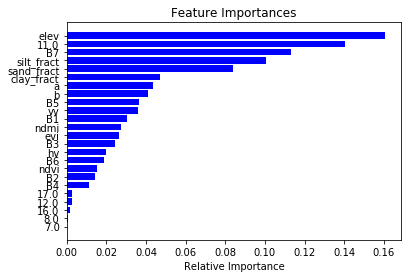

In [ ]:
imps = [v for v in results['importances']]
stacked = np.dstack(imps)
stacked = stacked.reshape(stacked.shape[1], stacked.shape[2])
mean_imps = np.mean(stacked, axis = 1)
indices = np.argsort(mean_imps)

features = [x for x in df.columns if x != "wa"]

plt.title('Feature Importances')
plt.barh(range(len(indices)), mean_imps[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# LSTM

In [ ]:
# Setup for the LSTM 

In [ ]:
df = analysis_df.copy()
df.drop(["id"], axis = 1, inplace = True)

In [ ]:
# Drop nonconsecutive rows 

t = df.copy()

filtered = []

for i in t.site.unique():
    sdf = t[t.site==i]
    
    for i in sdf.index:
        begin = i
        end = begin + pd.Timedelta(days=12)
        temp = sdf[begin:end]
        num_points = len(temp)
        if num_points<1:
            print(t)
        else:
            filtered.append(temp)

filt = pd.concat(filtered).dropna()

df = filt.copy()

In [ ]:
# Calc 12 day means 
df = df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna()

In [ ]:
# Drop the non interpolated landsat bands
df.drop(["B1", "B2", "B3", "B4", "B5", "B6", "B7"], axis = 1,inplace = True)
df.rename(columns={'B1_filt': 'B1', 'B2_filt': 'B2','B3_filt': 'B3','B4_filt': 'B4','B5_filt': 'B5','B6_filt': 'B6','B7_filt': 'B7'}, inplace=True)

In [ ]:
# One hot encode the landcover types 
one_hot = pd.get_dummies(df.lc_type, drop_first=True )
rdf = pd.concat([df, one_hot], axis = 1)
rdf = rdf.drop(["lc_type"], axis = 1)
df = rdf.dropna()

# Convert hte col names to strings 
df.columns = df.columns.map(str)

In [ ]:
# Add the time lagged predictors 
s1 = df.groupby(level="site").shift(1)
# s1 = df.groupby("site").shift(1)
df1 = df.join(s1.rename(columns=lambda x: x+"_t1"))

s2 = df.groupby(level="site").shift(2)
# s2 = df.groupby("site").shift(2)
df2 = df1.join(s2.rename(columns=lambda x: x+"_t2"))

df3 = df2.copy()

In [ ]:
# Drop irrelevant columns 

dropstrs = ["id",'site','precip', 'rzsm', 'ssm', 'psi_rz', "psi_s", "wa_", "lct_mean_all", "lct_mean_3_7", "wa_anom"]
dropcols = []

for i in df3.columns:
    for x in dropstrs:
        if x in i:
            dropcols.append(i)
            
df3 = df3.drop(dropcols, axis = 1)
# df = df3.dropna()

In [ ]:
# Reset the index and drop nans 
df = df3.reset_index(level='site')
df = df.dropna()

In [ ]:
# Modeling options

EPOCHS = 100
BATCHSIZE = 50
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l1(0.00005)
Breg = regularizers.l2(0.0001)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

def build_model(input_shape):
    # make the model 
    model = Sequential()
    
    model.add(LSTM(100, input_shape=input_shape, dropout = 0.15,recurrent_dropout=0.15,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(50, input_shape=input_shape, dropout = 0.15,recurrent_dropout=0.15,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.20,bias_regularizer= Breg))

    model.add(Dense(1))
    model.compile(loss=LOSS, optimizer= optimizers.Nadam(lr=0.01),
                  metrics=['mse'])
    
    return model

# K fold CV 

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
Y = df.wa.values
X = df.loc[:, df.columns != 'wa'].drop("site", axis = 1).values

NN_results = {"predicted":[],
            "actual": [] }

In [ ]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Scale data
#     transformer_x = StandardScaler().fit(X_train)
#     transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
    transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
    transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # LSTM params
    n_lags = 3
    n_features = 24

    # Reshape inputs
    X_train = X_train.reshape((X_train.shape[0], n_lags, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_lags, n_features))

    input_shape=(X_train.shape[1], X_train.shape[2])
    
    # Build model
    model = build_model(input_shape=input_shape)

    # Fit model
    model.fit(X_train, y_train, epochs=1000, batch_size=1000, verbose=2,validation_data=(X_test, y_test))
    
    y_pred = transformer_y.inverse_transform(model.predict(X_test).reshape(-1,1))
    y_test = transformer_y.inverse_transform(y_test)
              
    
    NN_results['predicted'].append(y_pred)
    NN_results['actual'].append(y_test)
    
    plt.scatter(y_pred, y_test)
    






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2180 samples, validate on 546 samples
Epoch 1/1000


In [ ]:
preds = [v for v in NN_results['predicted']]
preds = np.array([item for sublist in preds for item in sublist])

In [ ]:
obs = [v for v in NN_results['actual']]
obs = np.array([item for sublist in obs for item in sublist])

In [ ]:
A = np.vstack([preds.reshape(preds.shape[0]), np.ones(len(preds.reshape(preds.shape[0])))]).T

solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))
m, c = solution[0]
residuals = solution[1]
r2 = 1 - residuals / sum((obs - obs.mean())**2) 

In [ ]:
# Calc RMSE 
nn_rmse = float(np.sqrt(np.mean((obs - preds)**2)))

# Calc R^2
A = np.vstack([preds.reshape(preds.shape[0]), np.ones(len(preds.reshape(preds.shape[0])))]).T
solution = np.linalg.lstsq(A, obs)
m, c = solution[0]
residuals = solution[1]
nn_r2 = float(1 - residuals / sum((obs - obs.mean())**2))

# Calc ubRMSE
ubrmse = float(np.sqrt(np.mean(((obs - np.mean(obs)) - (preds - np.mean(preds)))**2)))

# Calc Bias 
bias = float(np.mean(obs - preds))

plt.scatter(preds, obs)
plt.plot(preds, m*preds + c, 'r', label='y = {}x + {}'.format(str(round(m[0],2)), str(round(c[0],2))))
plt.plot([0, 60], [0, 60], "gray", label = "1-1 line")
plt.title('''
            LSTM (t = 2, N = {})
            test set RMSE = {}
            test set $R^2$ = {}
            test set ubrmse = {}
            test set bias = {}

            '''.format(len(preds), round(nn_rmse,2), round(nn_r2,4), round(ubrmse,3), round(bias,3)))

plt.xlabel("predicted")
plt.ylabel("observed")
plt.legend()
plt.show()

# Leave one site out CV

In [ ]:
# out = {"train_preds":[],
#        "test_preds":[],
#        "train_act":[],
#        "test_act":[]  
#         }

In [ ]:
# # Randomly loop through the sites 
# for i in random.sample(set(df.site.unique()), len(df.site.unique())):

#     print("Processing {}".format(i))
    
#     # Select the random site as test, all other sites as train 
#     sdf = df[df.site == i]
#     y_test = sdf.wa
#     X_test = sdf.drop(["site","wa"], axis=1)

#     nsdf = df[df.site != i]
#     y_train = nsdf.wa 
#     X_train = nsdf.drop(["site","wa"], axis=1)
        
#     # Scale data
#     transformer_x = StandardScaler().fit(X_train)
#     transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
# #     transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
# #     transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
#     X_train = transformer_x.transform(X_train)
#     y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
#     X_test = transformer_x.transform(X_test)
#     y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
#     # LSTM params
#     n_lags = 3
#     n_features = 24

#     X_train = X_train.reshape((X_train.shape[0], n_lags, n_features))
#     X_test = X_test.reshape((X_test.shape[0], n_lags, n_features))

#     input_shape=(X_train.shape[1], X_train.shape[2])
    
#     model = build_model(input_shape=input_shape)
    
#     # Fit
# #     model.fit(X_train, y_train, epochs=1000, batch_size=1000, verbose=1)
    
#     train_history = model.fit(X_train, y_train,epochs = 500,
#                     batch_size=500,
#                     verbose=0, validation_data=(X_test, y_test))
#     loss = train_history.history['loss']
#     val_loss = train_history.history['val_loss']
#     val_acc = train_history.history['val_mse']

#     # Get the predictions
#     yhat_train = model.predict(X_train)
    
#     trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
#     trainY = transformer_y.inverse_transform(y_train)
    
#     yhat = model.predict(X_test)
#     testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
#     testY = transformer_y.inverse_transform(y_test)

#     trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
#     print('Train Score: %.2f RMSE' % (trainScore))
#     testScore = math.sqrt(mean_squared_error(y_test, testPredict))
#     print('Test Score: %.2f RMSE' % (testScore))
    
#     out["test_preds"] = testPredict
#     out["train_preds"] = trainPredict
    
#     out["test_act"] = testY
#     out["train_act"] = trainY
    
#     plt.plot(loss)
#     plt.plot(val_loss)
#     plt.legend(['loss', 'val_loss'])
#     plt.show()

#     plt.scatter(trainPredict, trainY)
#     plt.scatter(testPredict, testY)
#     plt.plot([0, 100], [0, 100], 'k-')
#     plt.title('''
#                 train set RMSE = {}
#                 test set RMSE = {}
#                 '''.format(round(trainScore,2),round(testScore,2)))

#     plt.xlabel("predicted")
#     plt.ylabel("actual")
#     plt.show()

# K fold CV

In [ ]:
# out = {"train_preds":[[]],
#        "test_preds":[[]],
#        "train_act":[[]],
#        "test_act":[[]]  
#         }

In [ ]:
# kf = KFold(n_splits=3, shuffle=True, random_state=10)
# Y = df.wa.values
# X = df.loc[:, df.columns != 'wa'].drop("site", axis = 1).values

In [ ]:
# for train_index, test_index in kf.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]
    
#     # Scale data
# #     transformer_x = StandardScaler().fit(X_train)
# #     transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
#     transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
#     transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
#     X_train = transformer_x.transform(X_train)
#     y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
#     X_test = transformer_x.transform(X_test)
#     y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
#     # LSTM params
#     n_lags = 3
#     n_features = 24

#     # Reshape inputs
#     X_train = X_train.reshape((X_train.shape[0], n_lags, n_features))
#     X_test = X_test.reshape((X_test.shape[0], n_lags, n_features))

#     input_shape=(X_train.shape[1], X_train.shape[2])
    
#     # Build model
#     model = build_model(input_shape=input_shape)
#     model.fit(X, y, epochs=300, shuffle=False, verbose=0)


#     # Fit model
# #     train_history = model.fit(X_train, y_train, epochs=1000, batch_size=250, verbose=1,validation_data=(X_test, y_test))
# #     loss = train_history.history['loss']
# #     val_loss = train_history.history['val_loss']
# #     val_acc = train_history.history['val_mean_squared_error']
    
#     # simple early stopping
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
#     # evaluate the model
#     scores = model.evaluate(X_test, y_test, verbose=1)
#     print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[1],np.std(scores[1]*100), scores[1]*100))

#     # Get the predictions
#     yhat_train = model.predict(X_train)
#     trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
#     trainY = transformer_y.inverse_transform(y_train)
    
#     yhat = model.predict(X_test)
#     testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
#     testY = transformer_y.inverse_transform(y_test)

#     # Calc RMSE 
#     rmse_test = np.sqrt(np.mean((y_test - testPredict)**2))
    
#     trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
#     print('Train Score: %.2f RMSE' % (trainScore))
#     testScore = np.sqrt(mean_squared_error(y_test, testPredict))
#     print('Test Score: %.2f RMSE' % (testScore))
#     print(rmse_test)
    
#     # Calc R^2
#     A = np.vstack([testPredict.reshape(testPredict.shape[0]), np.ones(len(testPredict.reshape(testPredict.shape[0])))]).T
#     solution = np.linalg.lstsq(A, testY)
#     m, c = solution[0]
#     residuals = solution[1]
#     r2 = 1 - residuals / sum((testY - testY.mean())**2) 
    
#     # Calc ubRMSE
#     ubrmse = np.sqrt(np.mean(((testY - np.mean(testY)) - (testPredict - np.mean(testPredict)))**2))
    
#     # Calc Bias 
#     bias = np.mean(testY - testPredict)
    
#     out["test_preds"].append(testPredict)
#     out["train_preds"].append(trainPredict)
    
#     out["test_act"].append(testY)
#     out["train_act"].append(trainY)
    
#     # Train / Test loss 
#     plt.plot(loss)
#     plt.plot(val_loss)
#     plt.legend(['loss', 'val_loss'])
#     plt.show()

#     # Predicted vs actual
#     plt.scatter(trainPredict, trainY, alpha = 0.2, label = "train")
#     plt.scatter(testPredict, testY, alpha = 0.2, label = "test")
#     plt.plot(testY, m*testY + c, 'r', label='y = {}x + {}'.format(str(round(m[0],2)), str(round(c[0],2))))
#     plt.plot([0, 100], [0, 100], "gray", label = "1-1 line")
#     plt.title('''
#                 train set RMSE = {}
#                 test set RMSE = {}
#                 test set $R^2$ = {}
#                 test set ubrmse = {}
#                 test set bias = {}

#                 '''.format(round(trainScore,2), round(testScore,2),round(r2[0],4), round(ubrmse,3), round(bias,3)))

#     plt.xlabel("predicted")
#     plt.ylabel("actual")
#     plt.legend()
#     plt.show()

In [ ]:
# all_preds = np.array([item for sublist in np.array([x for x in out['test_preds'] if len(x) !=0]) for item in sublist])
# all_obs = np.array([item for sublist in np.array([x for x in out['test_act'] if len(x) !=0]) for item in sublist])

In [ ]:
# preds = all_preds.reshape(all_preds.shape[0])
# obs = all_obs.reshape(all_obs.shape[0])

In [ ]:
# A = np.vstack([preds, np.ones(len(preds))]).T
# solution = np.linalg.lstsq(A, obs)
# m, c = solution[0]
# residuals = solution[1]
# r2 = 1 - residuals / sum((obs - obs.mean())**2) 

In [ ]:
# # KDE for predictions 

# # xy = np.vstack([obs,preds])
# # z = gaussian_kde(xy)(xy)

# plt.figure(figsize = (7,7))
# plt.scatter(all_obs.reshape(all_obs.shape[0]), all_preds.reshape(all_preds.shape[0]), s=10, cmap = "hot")
# plt.plot(obs, m*obs + c, 'b',linewidth=4, label='y = {}x + {}'.format(str(round(m,2)), str(round(c,2))))
# plt.plot([0, 100], [0, 100], "gray", label = "1-1 line")
# plt.xlim(0, 60)
# plt.ylim(0, 60)

# plt.xlabel("predicted")
# plt.ylabel("actual")
# plt.legend()
# plt.show()

In [ ]:
# # Gaussian process regression

# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
# gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

# # Reuse training data from previous 1D example
# gpr.fit(X_train, Y_train)

# # Compute posterior predictive mean and covariance
# mu_s, cov_s = gpr.predict(X, return_cov=True)

# # Obtain optimized kernel parameters
# l = gpr.kernel_.k2.get_params()['length_scale']
# sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

# # Plot the results
# plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)